# Mercari Price Suggestion Challenge
***
## Can you automatically suggest product prices to online sellers?
<img src = "../images/mercari_logo.png"/>

<b>Mercari</b> is biggest community - powered shopping app. The Mercari marketplace app allows users to buy and sell items quickly from their smartphones. Product pricing is a huge problem to them.

***

# Table Of Contents
***
### Business Problem
- [The business problem of Mercari](#problem)

### Objective
- [Goal of the notebook](#objective)

### Data Quality Check
- [Simple Inspection of Data](#inspection)

### Data Preprocessing
- [Data Cleansing](#cleansing)
- [Missing Values](#missingValues)
- [Imputation](#imputation)
- [Lowercase the string columns](#lowercase)
- [Data correction](#correction)

### Descriptive Statistics
- [Explore Data](#eda)
- [Price Distribution](#price)
- [Shipping Distribution](#shipping)
- [Item Condition Distribution](#itemCondition)
- [Category Distribution](#category)
- [Subcategory 1 Distribution](#subcategory1)
- [Subcategory 2 Distribution](#subcategory2)
- [Brand Distribution](#brand)

### Feature Engineering
- [Is Branded](#isBrand)
- [Item description and Name length](#itemDescription)
- [Unique word count on Item description and Name](#unique)

### Feature Extraction from text
- [TextPreprocessing](#textPreprocessing)
    - [Functions to normalize string](#functionsToNormalize)
    - [Normalize](#normalize)
- [Vectorization](#vectorization)
    - [Count Vectorizer](#count)
    - [Label Binarizer](#binarizer)
    - [TFIDF](#tfidf)
    
### Eli5
- [Eli5](#eli5)
- [Analyzing item description with eli5](#analyzingEli5)
- [Baseline Model with Count Vectorizer](#eli5Count)
- [Baseline Model with Count Vectorizer and Stop words](#eli5CountStop)
- [Baseline Model with TFIDF](#eli5Tfidf)
- [Baseline Model with TFIDF and Stop words](#eli5TfidfStop)
- [Baseline Model with TFIDF, Stop words and n-grams](#eli5TfidfStopNgrams)
- [RMSLE Summary](#eli5Rmsle)

### Encoding

### Merge the Sparse Matrices

### Train and Test Split

### Modelling
- [Define RMSLE fuction](#defineRMSLE)
- [Ridge Regression Cross Validation](#ridgeCV)
- [LGBM Cross Validation](#lgbmCV)
- [Ensemble](#ensemble)

### Save models to disk

### Predictions on Kaggle Test Dataset
- [Predictions by Ridge Model](#ridgePred)
- [Predictions by LGBM Model](#lgbmPred)
- [Predictions by Ensemble](#ensemblePred)

### Conclusion

***

<img src = '../images/mercari_logo_2.png'/>

<a id = 'problem'></a>
# Business problem
***
<b>Mercari</b> allows sellers to sell their products through their app. **The task of putting up the right/optimal price for the product** is left to the seller. **It is hard for a seller to estimate the right price**, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs. Mercari knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

<a id = 'objective'></a>
# Objective
***
The objective is to come up with the right pricing algorithm that can provide a pricing recommendation to the users. This will allow the users to see a suggested price before purchasing or selling.

# Import packages
***

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time

import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from scipy.sparse import vstack, hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Read the data
***

In [2]:
# Create training set
train = pd.read_csv('../input/train.tsv', sep = '\t')

In [3]:
# Create testing set
test = pd.read_csv('../input/test.tsv', sep = '\t',engine = 'python')

<a id = 'inspection'></a>
# Data Quality Check
***

In [4]:
# Examine the train dataset
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
# Examine the test dataset
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [6]:
# Check the type of our features. Are there any data inconsistencies?
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [7]:
# Can you check to see if there are any missing values in our train data set
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [8]:
# Can you check to see if there are any missing values in our test data set
test.isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name         True
brand_name            True
shipping             False
item_description     False
dtype: bool

In [9]:
# What is the size of the training set?
train.shape

(1482535, 8)

In [10]:
# What is the size of the test set?
test.shape

(693359, 7)

In [11]:
# Function to create combined set. 
# You would want to apply count vectorizer on combined set so you can get the list of all possible words.
def combineTrainTestSet():
    all_data = pd.concat((train.drop(['train_id', 'price'], axis = 1),
                          test.drop(['test_id'], axis = 1))).reset_index(drop=True)

    # Create the submission set (Only contains the test ID)
    submission = test[['test_id']]

    # size of train
    train_size = len(train)
    
    return (all_data, submission, train_size)

# Data Preprocessing
***

<a id = 'cleansing'></a>
## Data Cleansing
***

### Data with 0 price
***

In [12]:
# check data that has price set to 0
print("Count of records with 0 prices: ", train[train['price'] == 0].shape[0])

Count of records with 0 prices:  874


In [13]:
# deleting all records that has 0 price
train = train[train['price'] != 0].reset_index()

***

In [14]:
# Combine train and test dataset
all_data, submission, train_size = combineTrainTestSet()

<a id = 'missingValues'></a>
## Missing values
***

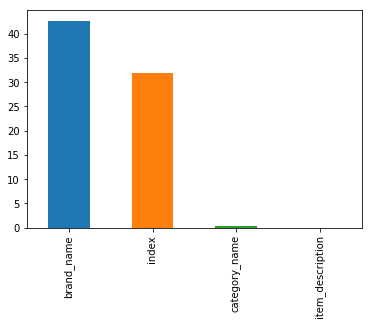

In [15]:
missing_total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() * 100/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Percent'] > 0]['Percent'].plot.bar(by = 'Percent', figsize=(6,4))

<a id = 'imputation'></a>
## Imputation
***

In [16]:
# Imputing missing values of brand name with "unbranded"
all_data['brand_name'] = all_data['brand_name'].fillna('unbranded')

# Imputing missing values of category_name with "other"
all_data['category_name'] = all_data['category_name'].fillna('other/other/other')

# Imputing missing values of item_description with "none"
all_data['item_description'] = all_data['item_description'].fillna('none')

<a id = 'lowercase'></a>
## Lowercase all string columns
***
Updating cases of all string values to lowercases

In [17]:
all_data['name'] = all_data['name'].str.lower()
all_data['category_name'] = all_data['category_name'].str.lower()
all_data['brand_name'] = all_data['brand_name'].str.lower()
all_data['item_description'] = all_data['item_description'].str.lower()

<a id = 'correction'></a>
## Data Correction
***

In [18]:
# Some item_description have values "no description yet" and some have "no description".
# Replacing them with "none"
all_data['item_description'] = all_data['item_description'].apply(lambda x: 'none' 
                                                                  if x == 'no description yet' else x)
all_data['item_description'] = all_data['item_description'].apply(lambda x: 'none' 
                                                                  if x == 'no description' else x)

*We are doing a minor **feature engineering** here. The category name is of the form **General category/Subcategory1/Subcategory2**. We will split it to three different columns: "category_main", "category_sub1" and "category_sub2".*

In [19]:
# The category name is of the form "General category/Subcategory1/Subcategory2"
# Let us segregate it in 3 columns
def segregate_category(text):
    try: return text.split("/")
    except: return ("other", "other", "other")

In [20]:
all_data['category_main'], all_data['category_sub1'], all_data['category_sub2'] = zip(*all_data['category_name'].apply(segregate_category))

We have values **other** in our subcategory columns category_sub1 and category_sub2. However, "women/other" is very different from "men/other". Similarly, "women/other/other" is very different than "men/other/other". Let us make correction to this.

### Example:

**Before transformation:**

| category_main | category_sub1 | category_sub2 |
| ------------- | ------------- | ------------- |
| women         | skirt         | other         |
| women         | other         | other         |
| men           | shirt         | other         |
| men           | other         | other         |
| other         | other         | other         |

**After transformation:**

| category_main | category_sub1 | category_sub2 |
| --- | --- | --- |
| women | skirt | skirt |
| women | women | women |
| men | shirt | shirt |
| men | men | men |
| other | other | other |

In [21]:
all_data.loc[all_data['category_sub1']=='other', 'category_sub1'] = all_data['category_main']
all_data.loc[all_data['category_sub2']=='other', 'category_sub2'] = all_data['category_sub1']

***

In [22]:
# Function to update changes in train and test set
def updateTrainTestDataset():
    global train
    global test
    ntrain = train.shape[0]
    ntest = test.shape[0]

    label = train['price']

    train = all_data[:ntrain]
    train['price'] = label
    test = all_data[ntrain:].reset_index().drop(['index'], axis = 1)

In [23]:
updateTrainTestDataset()

<a id = 'eda'></a>
# Exploratory Data Analysis
***

<img src = "../images/eCommerce.gif">

In [24]:
# Display the statistical overview of the categorical attributes
all_data.astype('object').describe().transpose()

,count,unique,top,freq
brand_name,2175020,5288,unbranded,927861
category_name,2175020,1310,"women/athletic apparel/pants, tights, leggings",88052
index,1.48166e+06,1.48166e+06,1.48253e+06,1
item_condition_id,2175020,5,1,940327
item_description,2175020,1850297,none,120970
name,2175020,1617196,bundle,4116
shipping,2175020,2,0,1201805
category_main,2175020,10,women,974038
category_sub1,2175020,121,athletic apparel,196975
category_sub2,2175020,950,t-shirts,90289


<b> Observations: </b>
1. There are approximately 121k, i.e., 5.5% of products with no item description.
2. There are 5287 unique brands and Nike being the most occuring brand with near 79k products.
3. There are 927861 products (42%) with missing brand value, which supposedly mean they are unbranded.
4. Majority of items sold on Mercari are women's.
5. 1201805 (44.74%) of shipping prices were paid by buyers, and remaining 973530 (55.25%) of the times, shipping prices were paid by the seller.
6. T-shirts are most sold products in Mercari.

In [25]:
# Display the statistical overview of the numerical attributes
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,1481661.0,741243.718093,427971.458448,0.0,370588.0,741238.0,1111877.0,1482534.0
item_condition_id,2175020.0,1.906933,0.903240,1.0,1.0,2.0,3.0,5.0
shipping,2175020.0,0.447451,0.497231,0.0,0.0,0.0,1.0,1.0


## Target variable: Price
***

In [26]:
# Display the statistic overview of target variable 'price'
train.price.describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

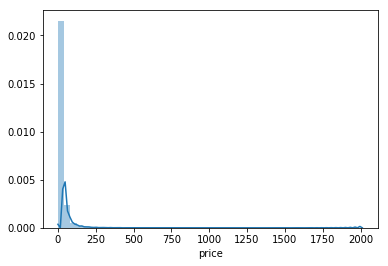

In [27]:
#histogram
sns.distplot(train['price'])

<a id = 'price'></a>
## Price Distribution
***

**Summary**
1. The min value of price is 0. There are 874 products for 0 dollars.
2. The mean price is 26.7 dollars.
3. The median price is 17 dollars.
2. The third quartile of the price is on 29 dollars, while the max value is 2009 dollars. Thats a huge difference.
3. The price is highly skewed.
3. Only 2.82% of products have its price higher than 100 currency value.

**Actions to take**
<br>
Log transformation has to be applied on price.

**Why log transformation?**
<br>
The price distribution is highly skewed, e.g., only 2.8% of data is more than 100 dollars and the max value is 2009 dollars. This reduces the relevance of the errors (in the predicted value) on lower prices. Log transformation converges the distribution to a smaller scale, which means that the difference between different values of price will reduce. This, in turn, would make the distribution more normal.

**Procedure**

**Step 1 Log Transformation:** np.log(train['price']+1)

**Step 2 Predict with Log Transformation:** test_pred = model.predict(X_test)

**Step 3 Convert back to original value by Exponential Transformation** Y_test = np.expm1(test_pred)

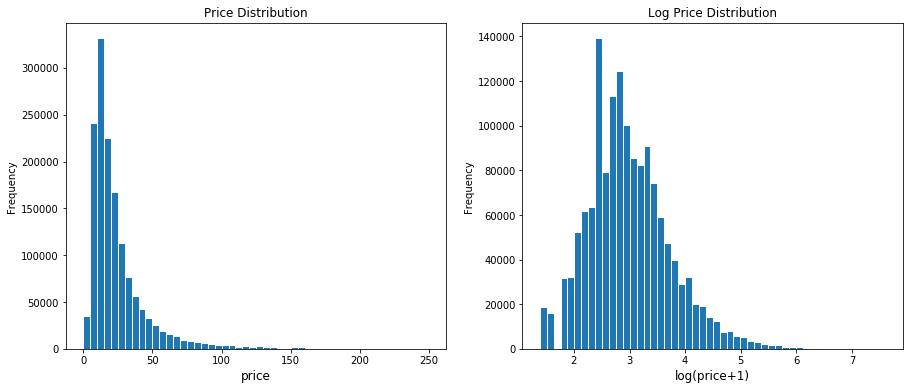

In [28]:
# Plot Price Distribution
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

#Plot Log Price Distribution
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

plt.show()

In [29]:
y_train = np.log1p(train['price'])

# Shipping
***

In [30]:
all_data['shipping'].value_counts() / len(all_data)

0    0.552549
1    0.447451
Name: shipping, dtype: float64

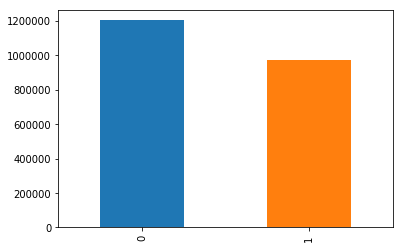

In [31]:
all_data['shipping'].value_counts().plot.bar()

**Observations:**
55% of times sellers paid the shipping charges.

## Price Distribution by Shipping Type
***
**Hypothesis**
I have an intution that the product charges are higher when sellers pay the shipping charges. Let's see if it holds true.

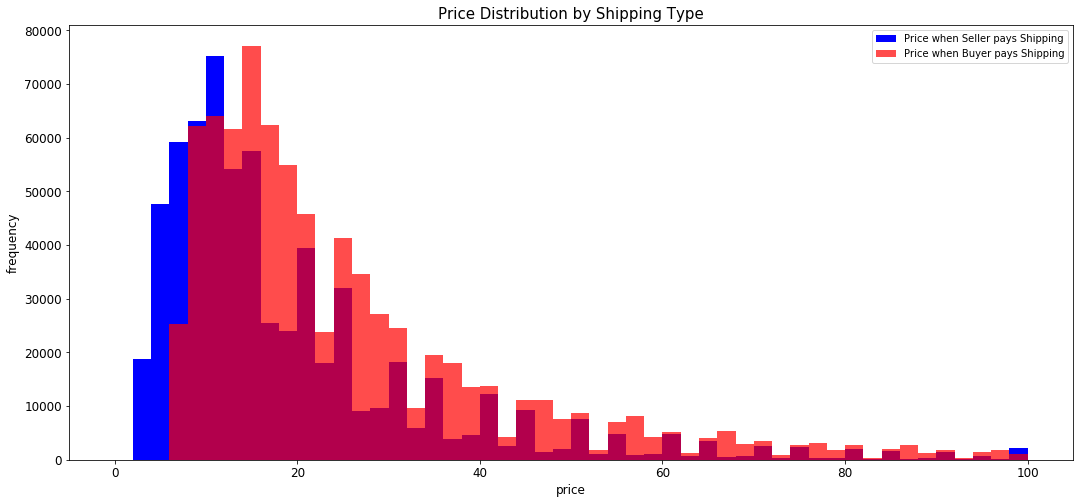

In [32]:
shipping_fee_by_buyer = train.loc[train['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[train['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))

ax.hist(shipping_fee_by_seller, color='blue', alpha=1.0, bins=50, range = [0, 100],label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='red', alpha=0.7, bins=50, range = [0, 100],label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

## Average price for Shipping type
***

In [33]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping')
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.58 if seller pays shipping
The average price is 30.13 if buyer pays shipping


**Observations:**
<br>
Mostly for low priced items, shipping does increase the product charges. However, for most of the products which are priced more than 15 dollars, our hypothesis doesn't hold true

<a id = 'itemCondition'></a>
## Item Condition
***

In [34]:
all_data['item_condition_id'].value_counts() / len(all_data)

1    0.432330
3    0.291292
2    0.253216
4    0.021516
5    0.001646
Name: item_condition_id, dtype: float64

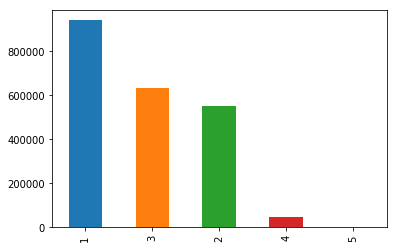

In [35]:
all_data['item_condition_id'].value_counts().plot.bar()

**Observations:**
<br>
There are only 2% of products with condition as bad as 4 or 5.

<a id = 'category'></a>
## Category
***

In [36]:
all_data['category_main'].value_counts()

women                     974038
beauty                    304990
kids                      251780
electronics               180311
men                       137675
home                       99797
other                      76110
vintage & collectibles     67929
handmade                   45170
sports & outdoors          37220
Name: category_main, dtype: int64

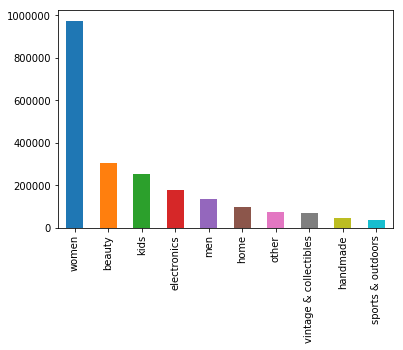

In [37]:
all_data['category_main'].value_counts().plot.bar()

**Observations:**
<br>
44% of products sold in Mercari come under the category "women", whereas only 6% of products are "men's".

## Category versus Price
***

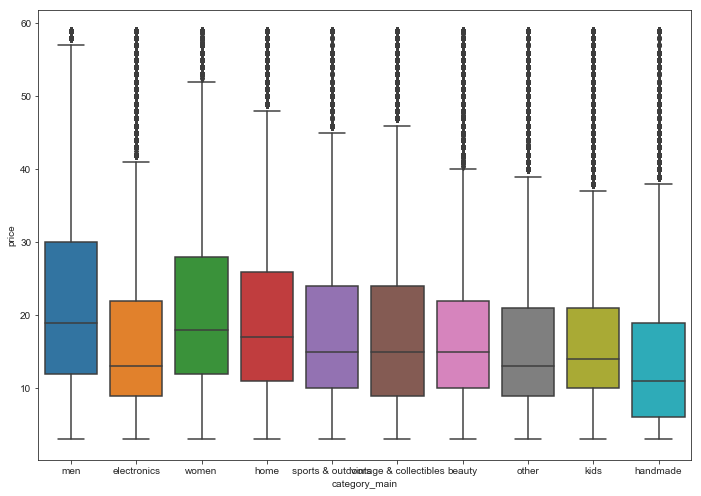

In [38]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.boxplot(
    x='category_main',
    y='price',
    data=train[train['price'] < 60],
    ax = ax
)

<a id = 'subcategory1'></a>
## Subcategory 1
***
There are 121 unique values of subcategory 1. Let's explore top 20 ones.

In [39]:
top_20_subcategory1 = all_data['category_sub1'].value_counts()[:20].reset_index()
top_20_subcategory1

,index,category_sub1
0,athletic apparel,196975
1,makeup,182992
2,tops & blouses,157201
3,shoes,147139
4,jewelry,90352
5,toys,85184
6,cell phones & accessories,78249
7,women's handbags,67221
8,dresses,67220
9,women's accessories,62032


In [40]:
list(top_20_subcategory1['index'])[0:10]

['athletic apparel',
 'makeup',
 'tops & blouses',
 'shoes',
 'jewelry',
 'toys',
 'cell phones & accessories',
 "women's handbags",
 'dresses',
 "women's accessories"]

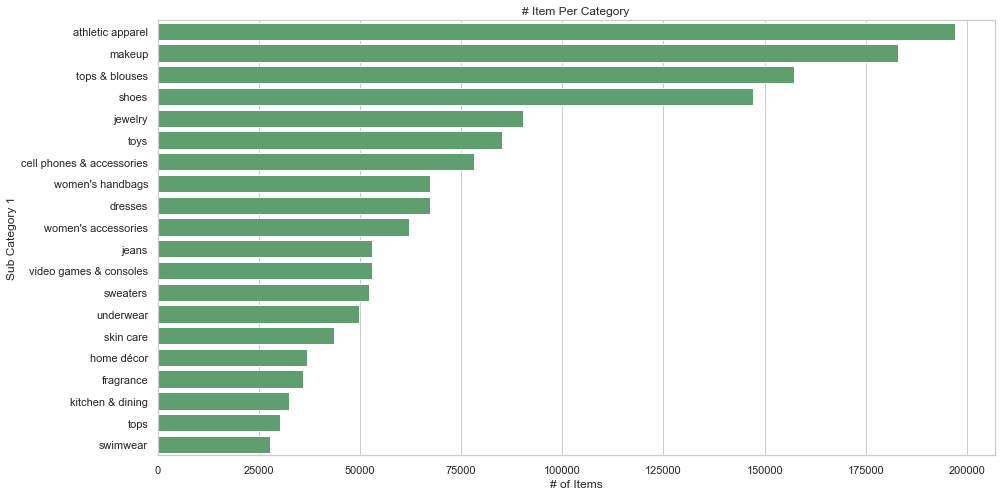

In [41]:
sns.set(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x='category_sub1', y='index', data=top_20_subcategory1, label='# Item per category', color='g')

# Add a legend and informative axis label
ax.set( ylabel="Sub Category 1", title='# Item Per Category',
       xlabel="# of Items")

plt.show()

<a id = 'subcategory2'></a>
## Subcategory 2
***
There are 950 unique values of subcategory 2. Let's explore top 20 ones.

In [42]:
top_20_subcategory2 = all_data['category_sub2'].value_counts()[:20].reset_index()
top_20_subcategory2

,index,category_sub2
0,t-shirts,90289
1,"pants, tights, leggings",88052
2,face,73519
3,shoes,48207
4,lips,45456
5,games,45448
6,athletic,39671
7,women,38530
8,eyes,38382
9,"cases, covers & skins",36078


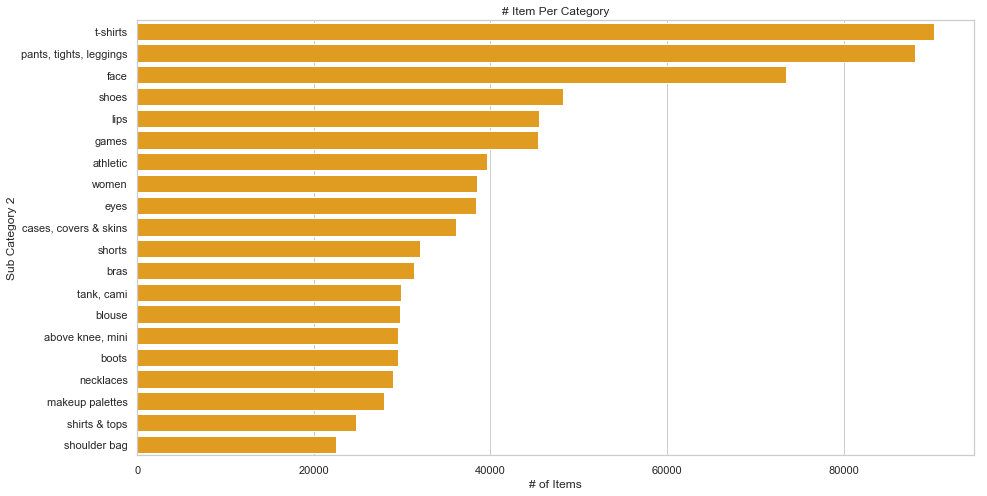

In [43]:
sns.set(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x='category_sub2', y='index', data=top_20_subcategory2, label='# Item per category', color='orange')

# Add a legend and informative axis label
ax.set( ylabel="Sub Category 2", title='# Item Per Category',
       xlabel="# of Items")

plt.show()

<a id = 'brand'></a>
## Brand
***
There are 5290 unique brands in complete dataset. However, the training set only have 4810 brands.

In [44]:
# Amount of unique brand names
all_data['brand_name'].nunique()

5288

In [45]:
# Amount of unique brand names in training set
train['brand_name'].nunique()

4808

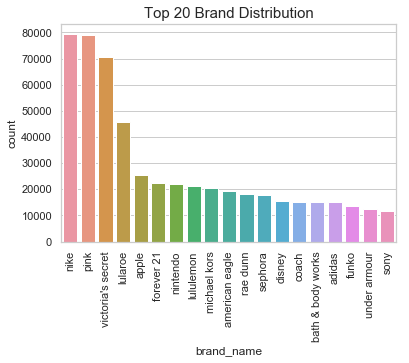

In [46]:
# Top 20 Brand Distribution
b20 = all_data['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

**Observations:**
<br>
1. There are 5290 unique brands in complete dataset, while there are only 4810 of them in training dataset.
1. There are 928207 products (42%) which are either unbranded or of unknown brand.
2. Nike and Pink are the top brands whose products are sold in Mercari.

### Brand versus Price
***

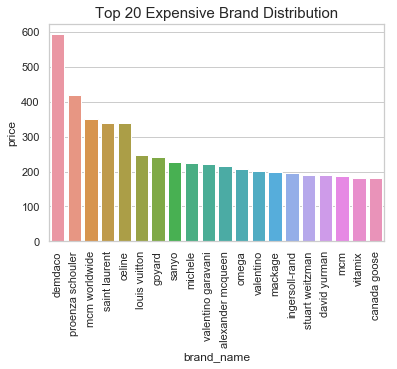

In [47]:
# Top 20 expensive brands
top_20_exp_brand = pd.DataFrame(train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Expensive Brand Distribution', fontsize=15)
plt.show()

# Feature Engineering
***

<a id = 'isBrand'></a>
## Is Branded
***
Let us make a new feature "is_branded". If the item is of any known brand, we will update it with 1, otherwise 0.

In [48]:
all_data.loc[(all_data.brand_name != 'unbranded'),'is_branded'] = 1
all_data.loc[(all_data.brand_name == 'unbranded'),'is_branded'] = 0
updateTrainTestDataset()

### Is Branded distribution
***

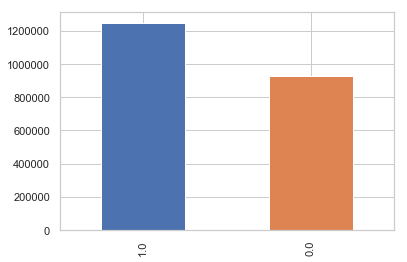

In [49]:
all_data['is_branded'].value_counts().plot.bar()

### Is branded versus price
***

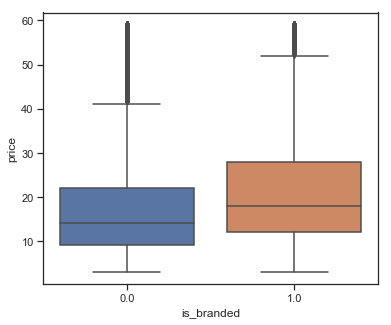

In [50]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(6, 5)

sns.boxplot(
    x='is_branded',
    y='price',
    data=train[train['price'] < 60],
    ax = ax
)

<a id = 'itemDescription'></a>
## Item Description and Name length
***
Does the length of description and name have some affect on pricing?

In [51]:
description_length = all_data['item_description'].astype(str).apply(lambda x : len(str(x)))
name_length = all_data['name'].astype(str).apply(lambda x : len(str(x)))
all_data['length'] = description_length + name_length
updateTrainTestDataset()

### Description length versus price
***

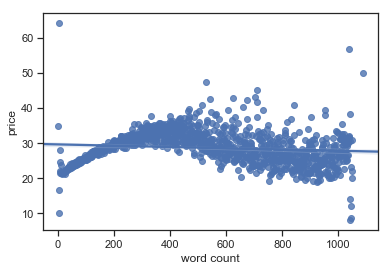

In [52]:
df = train.groupby('length')['price'].mean().reset_index()
sns.regplot(x=df["length"], y=(df["price"]))
plt.xlabel("word count")
plt.show()

<a id = 'unique'></a>
## Unique word count on Item Description and Name
***

In [53]:
def count_unique(text):
    text_list = text.split()
    return len(set(text_list))

description_unique = all_data['item_description'].astype(str).apply(lambda x : count_unique(str(x)))
name_unique = all_data['name'].astype(str).apply(lambda x : count_unique(str(x)))
all_data['unique'] = description_unique + name_unique
updateTrainTestDataset()

### Count of unique words in description versus price
***

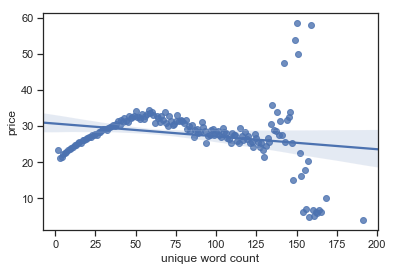

In [54]:
df = train.groupby('unique')['price'].mean().reset_index()
sns.regplot(x=df["unique"], y=(df["price"]))
plt.xlabel("unique word count")
plt.show()

<a id = 'textPreprocessing'></a>
# Feature Extraction from Text
***

<img src = "../images/nlp.png">

## Text pre-processing
The texts has to be normalised. We will be performing following steps:
- **Removing Punctuations**
- **Removing Digits**
- **Removing Stop Words**
- **Lowercasing the Words**
- **Lemmatization:** Words in third person are changed to first person, and verbs in past and present tenses are changed changed to present.
- **Stemming:** Words are reduced to their root form
- **Tokenization:** Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

## Bag of Words

If we want to use text in Machine Learning algorithms, we’ll have to convert them to a numerical representation. It should be no surprise that computers are very well at handling numbers. So, we convert text to a numerical representation called a feature vector. A feature vector can be as simple as a list of numbers.
<br>
The **bag-of-words model** is one of the feature extraction algorithms for text. The bag of words model **ignores grammar and order of words**.
- In python, we use **CountVectorizer**, **LabelBinarizer** and **TFIDF** are some ways of **vectorizing** texts.
- To preserve some ordering of text, we can introduce **n-grams** into our vectorization of words.

In [55]:
# generating list of stop words
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [56]:
# generating list of punctuation marks
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

<a id = 'functionsToNormalize'></a>
### Functions to normalize string
***

In [57]:
import string

# Function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Function to remove digits
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

<a id = 'normalize'></a>
### Normalize
***

In [58]:
# Stem the Words
porter = PorterStemmer()
all_data['item_description'] = all_data['item_description'].apply(porter.stem)

all_data['item_description'] = all_data['item_description'].apply(remove_punctuation)
all_data['item_description'] = all_data['item_description'].apply(remove_stop_words)
all_data['item_description'] = all_data['item_description'].apply(remove_digits)

all_data['name'] = all_data['name'].apply(remove_punctuation)
all_data['name'] = all_data['name'].apply(remove_stop_words)
all_data['name'] = all_data['name'].apply(remove_digits)

updateTrainTestDataset()

<a id = 'vectorization'></a>
## Vectorization
***
Vectorization of string columns in dataframe can be done in threee different ways:
- Frequency Weight
- TF-IDF Weight
- Binary

**CountVectorizer**: Returns an encoded vector with integer count for each word

**TF-IDF(min_df, max_df, n-gram)**: Returns encoded vector with weighted count for each word (utilizes the word in the document in corresponsdence to the whole corpus, to keep it short, more emphasis on the rarity of a word).  This is good because we want to find frequent terms from that document that isn't so frequent within the whole document corpus.

**LabelBinarizer**: Get's all the word and assigns it to its own column. 0 means it's there and 1 means not (example with brand names)

<a id = 'count'></a>
## Count Vectorizer
***

In [59]:
# CountVectorizer - name & categories
cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(all_data['name'])
X_category_main = cv.fit_transform(all_data['category_main'])
X_category_sub1 = cv.fit_transform(all_data['category_sub1'])
X_category_sub2 = cv.fit_transform(all_data['category_sub2'])

In [60]:
print("Item Name Shape: " + str(X_name.shape))
print("Category Main Shape: " + str(X_category_main.shape))
print("Category Sub1 Shape: " + str(X_category_sub1.shape))
print("Category Sub2 Shape: " + str(X_category_sub2.shape))

Item Name Shape: (2175020, 20477)
Category Main Shape: (2175020, 12)
Category Sub1 Shape: (2175020, 144)
Category Sub2 Shape: (2175020, 868)


<a id = 'binarizer'></a>
## Label Binarizer
***

In [68]:
# Apply LabelBinarizer to "brand_name"
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(all_data['brand_name'])

In [69]:
print("Item Brand Shape: " + str(X_brand.shape))

Item Brand Shape: (2175020, 5288)


<a id = 'tfidf'></a>
## TFIDF
***

In [70]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(all_data['item_description'])

In [71]:
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (2175020, 55000)


<a id = 'eli5'></a>
<img src='../images/eli5_3.png'>

# Eli5
***
## ELI5: Explain like I am 5
- Eli5 s a Python package which helps to debug machine learning classifiers and explain their predictions.
- In our case, Eli5 will help us to see what the model has learned from the text features.

## Basic usage
There are two main ways to look at a classification or a regression model:

1. inspect model parameters and try to figure out how the model works globally;
2. inspect an individual prediction of a model, try to figure out why the model makes the decision it makes.

For (1) ELI5 provides eli5.show_weights() function; for (2) it provides eli5.show_prediction() function.

e.g.,<br>
import eli5<br>
eli5.show_weights(clf)<br>
gives an explanation like this:

<img src = '../images/weights.png'/>

In our case, we will use it to see the correlation of each feature/text with the target variable. We can inspect features and weights because we are using a bag-of-words vectorizer and a linear classifier (so there is a direct mapping between individual words and classifier coefficients). 

### How does Eli5 Work?
It shows us the correlation of each feature/text with the target variable. We can inspect features and weights because we are using a bag-of-words vectorizer and a linear classifier (so there is a direct mapping between individual words and classifier coefficients). 

*source: https://eli5.readthedocs.io/en/latest/overview.html#installation*

<a id = 'analyzingEli5'></a>
## Analyzing item description with Eli5
***
We will use only 10% of data for this purpose

In [128]:
train.shape[0]

1481661

In [127]:
reduced_X_train = train.loc[0:1481661, :]
reduced_y_train = y_train[0:1481661]

In [132]:
# Definte RMSLE Cross Validation Function
def rmsle_cv(model):
    kf = KFold(shuffle=True, random_state=42).get_n_splits(reduced_X_train['item_description'])
    rmse= np.sqrt(-cross_val_score(model, reduced_X_train['item_description'], reduced_y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

<a id = 'eli5Count'></a>
## Baseline Model with CountVectorizer
***

In [133]:
vec = CountVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

cv_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_rmsle))

The Validation Score is: 0.6259487648048925


In [135]:
import eli5
eli5.show_weights(pipe, vec=vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+1.468,substitut
+1.239,hatchim
+1.035,visa
+1.035,dockatot
+1.020,louboutins
+1.019,neverful
+1.013,vnd
+1.011,xperia
+0.986,nmds
+0.981,accucheck


In [136]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

<a id = 'eli5CountStop'></a>
## Baseline Model with CountVectorizer and Stop Words
***

In [137]:
vec = CountVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

cv_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_sw_rmsle))

The Validation Score is: 0.6266686967678374


In [138]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

<a id = 'eli5Tfidf'></a>
## Baseline Model with TF-IDF
***

In [139]:
vec = TfidfVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_rmsle))

The Validation Score is: 0.599742750402696


In [140]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

<a id = 'eli5TfidfStop'></a>
## Baseline Model with TF-IDF and Stop Words
***

In [141]:
vec = TfidfVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_rmsle))

The Validation Score is: 0.6011751689044808


In [142]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

<a id = 'eli5TfidfNgrams'></a>
## Baseline Model with TF-IDF, Stop Words and N-Grams
***

In [143]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(reduced_X_train['item_description'], reduced_y_train)

tfidf_sw_ng_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmsle))

The Validation Score is: 0.5707428237325486


In [144]:
eli5.show_prediction(clf, doc=reduced_X_train['item_description'][1297], vec=vec)

<a id = 'eli5Rmsle'></a>
## RMSLE Summary
***
TF-IDF + Stop Words + N-Grams works best

In [145]:
print ("RMSLE Score: " + str(cv_rmsle) + " | CountVectorizer")
print ("RMSLE Score: " + str(cv_sw_rmsle) + " | CountVectorizer | Stop Words")
print ("RMSLE Score: " + str(tfidf_rmsle) + " | TF-IDF")
print ("RMSLE Score: " + str(tfidf_sw_rmsle) + " | TF-IDF | Stop Words")
print ("RMSLE Score: " + str(tfidf_sw_ng_rmsle) + " | TF-IDF | Stop Words | N-Grams")

RMSLE Score: 0.6259487648048925 | CountVectorizer
RMSLE Score: 0.6266686967678374 | CountVectorizer | Stop Words
RMSLE Score: 0.599742750402696 | TF-IDF
RMSLE Score: 0.6011751689044808 | TF-IDF | Stop Words
RMSLE Score: 0.5707428237325486 | TF-IDF | Stop Words | N-Grams


***

# Encoding
***

In [146]:
# Apply get_dummies to "item_condition_id" and "shipping" and then convert into a CSR Matrix
X_dummies = csr_matrix(pd.get_dummies(all_data[['item_condition_id', 'shipping']], sparse=True).values)

# Merge the Sparse Matrices
***

In [148]:
# converting numerical columns to matrix
X_numerical = all_data[['is_branded', 'length', 'unique']].as_matrix()

# Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_name, X_category_main, X_category_sub1, X_category_sub2, X_numerical)).tocsr()

In [149]:
sparse_merge.shape

(2175020, 76506)

# Train and Test Split
***

In [150]:
X_train_sparse = sparse_merge[:train_size]

X_test = sparse_merge[train_size:]

# Modelling
***

<a id = 'defineRmsle'></a>
## Define RMSLE Function
***

In [151]:
def get_rmsle(y, pred): return np.sqrt(mean_squared_error(y, pred))

<a id = 'ridgeCV'></a>
## Ridge Regression Cross Validation
***

In [162]:
%%time

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train_sparse):
    # Define LGBM Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
    
    # Fit LGBM Model
    model_ridge.fit(X_train_sparse[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(X_train_sparse[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(X_train_sparse[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    print(f'Ridge Training RMSLE: {rmsle_train:.5f}')
    print(f'Ridge Validation RMSLE: {rmsle_valid:.5f}')

Ridge Training RMSLE: 0.55004
Ridge Validation RMSLE: 0.54978
Ridge Training RMSLE: 0.54935
Ridge Validation RMSLE: 0.55065
Ridge Training RMSLE: 0.54696
Ridge Validation RMSLE: 0.54841
CPU times: user 32min 2s, sys: 8.47 s, total: 32min 11s
Wall time: 32min 18s


<a id = 'lgbmCV'></a>
## LGBM Cross Validation
***
### Why LGBM?
- We need to process huge data. LGBM is a Boosting algorithm that is 'light' (high speed).
- Takes lower memory to run.
- Can handle large size of data.

In [161]:
%%time
import lightgbm as lgb

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train_sparse):
    # Define LGBM Model
    model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
    # Fit LGBM Model
    model_lgb.fit(X_train_sparse[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_lgb.predict(X_train_sparse[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_lgb.predict(X_train_sparse[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    print(f'LGBM Training RMSLE: {rmsle_train:.5f}')
    print(f'LGBM Validation RMSLE: {rmsle_valid:.5f}')
    

LGBM Training RMSLE: 0.48518
LGBM Validation RMSLE: 0.48984
LGBM Training RMSLE: 0.48503
LGBM Validation RMSLE: 0.49020
LGBM Training RMSLE: 0.48450
LGBM Validation RMSLE: 0.49069
CPU times: user 2h 40min 16s, sys: 1min 28s, total: 2h 41min 44s
Wall time: 57min 26s


<a id = 'ensemble'></a>
## Ensemble
***
Ensemble modeling is the process of running two or more related but different analytical models and then synthesizing the results into a single score or spread in order to improve the accuracy of predictive analytics.

<img src = "../images/ensemble.png">

### Train Test Split

In [163]:
# Train and Test Split
train_X, test_X, train_y, test_y = train_test_split(X_train_sparse, y_train, test_size=0.2, random_state=144)

### LGBM
***

In [164]:
model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
model_lgb.fit(train_X, train_y)

# Predict with LGBM Model
lgbm_y_pred = model_lgb.predict(test_X)

In [165]:
lgbm_rmsle = get_rmsle(lgbm_y_pred, test_y)

print(f'LGBM RMSLE: {lgbm_rmsle:.5f}')

LGBM RMSLE: 0.48843


### Ridge Regression
***

In [166]:
model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
model_ridge.fit(train_X, train_y)
    
# Evaluate Training Score
ridge_y_pred = model_ridge.predict(test_X)

In [167]:
ridge_rmsle = get_rmsle(ridge_y_pred, test_y)

print(f'Ridge RMSLE: {ridge_rmsle:.5f}')

Ridge RMSLE: 0.54423


### Ensemble Model
***

In [168]:
ensemble_y_pred = (lgbm_y_pred+ridge_y_pred)/2

ensemble_rmsle = get_rmsle(ensemble_y_pred, test_y)

print(f'Ensemble RMSLE: {ensemble_rmsle:.5f}')

Ensemble RMSLE: 0.50599


# Save the models to disk
***

In [179]:
import pickle

modelList = [(model_lgb, 'Lgb.sav'),
            (model_ridge, 'RidgeRegression.sav')]

for model, filename in modelList:
    pickle.dump(model, open("../models/"+filename, 'wb'))

# Predictions on Kaggle Test data
***

<a id = 'ridgePred'></a>
### Predictions by Ridge
***

In [169]:
ridge_kaggle_y = model_ridge.predict(X_test)

In [173]:
# inverse log transformation
submission["price"] = np.expm1(ridge_kaggle_y)

In [174]:
# first submission file
submission.to_csv('../submissions/submission_ridge.csv',index=False)

<a id = 'lgbmPred'></a>
### Predictions by LGBM
***

In [175]:
lgbm_kaggle_y = model_lgb.predict(X_test)

In [176]:
# inverse log transformation
submission["price"] = np.expm1(lgbm_kaggle_y)

In [177]:
# second submission file
submission.to_csv('../submissions/submission_lgbm.csv',index=False)

<a id = 'ensemblePred'></a>
### Predictions by Ensemble
***

In [178]:
ensemble_y_kaggle = (lgbm_kaggle_y+ridge_kaggle_y)/2

# inverse log transformation
submission["price"] = np.expm1(ensemble_y_kaggle)

# third submission file
submission.to_csv('../submissions/submission_ensemble.csv',index=False)

# Conclusion
***
I have reached the end of the notebook here. In this notebook, apart from the Exploratory Data Analysis, I have explored various techniques to preprocess text and use it as features in a predictive model. I have made use of the python package Eli5 to understand which words have been influential in determining the price of the products. I have also built predictive models using Ridge Regression, Light GBM and the ensemble of both the models to predict prices of the products sold in Mercari. The best rmsle score I achieved is 0.48843.<br>
Also, this notebook is a work in progress and I will keep on updating the notebook with time.